## Steps

- Importing a DataFrame
- Visualize the Data
- Cleanup and Transform the Data
- Encode the Data
- Split Training and Test Sets
- Fine Tune Algorithms
- Cross Validate with KFold
- Upload to Kaggle

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
df = pd.read_csv("titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [44]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2,random_state=42)


## Visualize

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

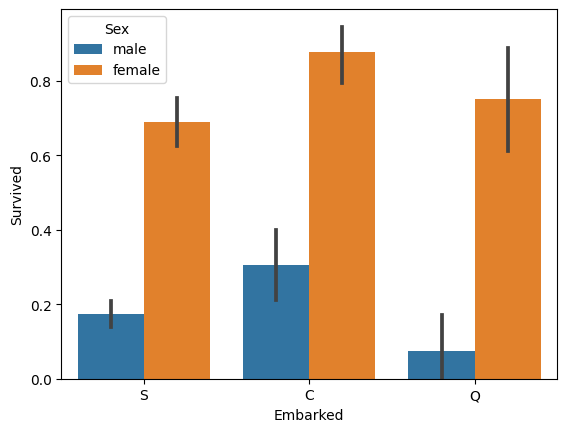

In [45]:
sns.barplot(x='Embarked',y='Survived',hue='Sex',data=df)

In [46]:
df.Parch.unique()

array([0, 1, 2, 5, 3, 4, 6])

<AxesSubplot:xlabel='Parch', ylabel='Survived'>

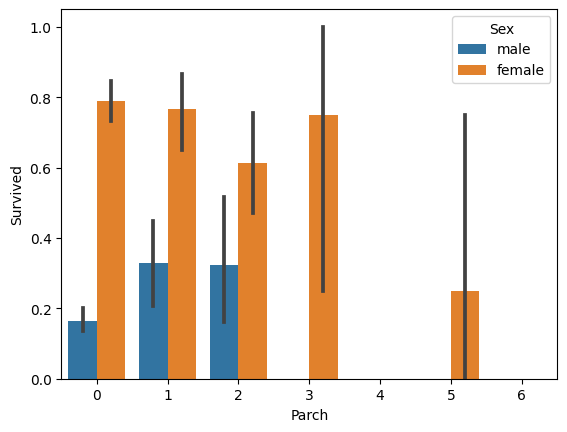

In [47]:
sns.barplot(x='Parch',y='Survived',hue='Sex',data=df)

### Transform

In [48]:
def simplify_ages(df):
    df.Age = df.Age.fillna(df.Age.mean())
    bins = (-1,0,5,12,18,25,35,60,120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins=(-1,0,8,15,31,1000)
    group_names = ['Unknown','1_quartile','2_quartile','3_quartile','4_quartile']
    
    res = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare=res
    return df
    
def format_name(df):
    df['Lname'] = df['Name'].apply(lambda x: x.split(',')[0])
    df['First'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df

def drop_feature(df):
    return df.drop(['Ticket','Name','Embarked'],axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_feature(df)
    return df


In [49]:
df_train = transform_features(df_train)
df_test = transform_features(df_test)


## some final encodings

In [50]:
from sklearn import preprocessing

def encode_features(df_train, df_test):
    features = ['Fare','Cabin','Age','Sex','Lname','First']
    df_combined = pd.concat([df_train[features],df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test

df_train, df_test = encode_features(df_train, df_test)

df_train.head()
        
        
        

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,First
331,332,0,1,1,0,0,0,2,2,468,17
733,734,0,2,1,4,0,0,1,7,55,17
382,383,0,3,1,6,0,0,0,7,602,17
704,705,0,3,1,6,1,0,0,7,235,17
813,814,0,3,0,2,4,2,3,7,16,14


In [51]:
# splitting up the training data


In [52]:
from sklearn.model_selection import train_test_split
x_all = df_train.drop(['Survived','PassengerId'],axis=1)
y_all = df_train['Survived']

num_test=0.20

X_train, X_test, y_train, y_test = train_test_split(x_all, y_all, test_size=num_test, random_state=23)


## Fitting and Tuning an algorithm

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, max_features='sqrt',
                       min_samples_split=3, n_estimators=9)

In [56]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.8111888111888111


In [77]:
from sklearn.model_selection import KFold

def run_kfold(clf,X_all):
    kf = KFold(n_splits=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf.split(X_all):
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(clf,x_all)

Fold 1 accuracy: 0.8472222222222222
Fold 2 accuracy: 0.7916666666666666
Fold 3 accuracy: 0.7464788732394366
Fold 4 accuracy: 0.9154929577464789
Fold 5 accuracy: 0.8591549295774648
Fold 6 accuracy: 0.8169014084507042
Fold 7 accuracy: 0.7605633802816901
Fold 8 accuracy: 0.8169014084507042
Fold 9 accuracy: 0.7464788732394366
Fold 10 accuracy: 0.9295774647887324
Mean Accuracy: 0.8230438184663538
